# Setting openai

In [2]:
# !pip install pdfplumber

In [1]:
# !pip list

In [9]:
#pip list --format=freeze > requirements.txt

In [1]:
import os
import json
import requests
import datetime
from openai import AzureOpenAI
from dotenv import load_dotenv
import pdfplumber
import tiktoken
from datetime import datetime
from PIL import Image
import io
import re

# 24.07.10 test
load_dotenv()

client = AzureOpenAI(
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT","").strip(),
    api_key        = os.getenv("AZURE_OPENAI_API_KEY"),
    api_version    = os.getenv("OPENAI_API_VERSION")
)

deployment_name = os.getenv('DEPLOYMENT_NAME') # gpt-4o

In [77]:
# 속도 테스트

response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            {"role" : "system", "content" :'당신은 친절한 AI 도우미입니다.'},
            {"role" : "user", "content" : 'gpt-4o 결과를 빨리 받을 수 있는 프롬프팅 방법은 어떤거야?'}
        ]
)

print(response.choices[0].message.content)

GTP-4o 또는 GPT-4 모델을 사용할 때 결과를 빠르게 받을 수 있는 몇 가지 프롬프팅 전략이 있습니다. 다음은 그 중 몇 가지입니다:

1. **명확하고 간결한 질문**: 긴 문장보다는 짧고 명확한 질문을 활용하세요. 예를 들어, "AI의 장단점을 설명해줘" 대신 "AI의 장점과 단점은?"이라고 묻는 것이 더 효과적일 수 있습니다.

2. **맥락 제공**: 필요한 경우 최소한의 배경 정보를 제공하여 AI가 질문의 맥락을 이해하도록 돕습니다. 그러나 불필요한 정보를 너무 많이 포함하지 않도록 주의하세요.

3. **단계적 질문**: 복잡한 질문은 여러 단계로 나누어 간단하게 물어보세요. 예를 들어, "AI가 일자리 시장에 미치는 영향"이라는 질문 대신 "AI가 일자리 시장에 긍정적 영향 미친 사례?"와 "AI가 일자리를 줄인 사례?"라는 두 개의 질문으로 나눌 수 있습니다.

4. **명확한 목적**: 질문의 목적을 명확히 하고 필요한 정보만 요청하세요. 예를 들어, "GPT-4의 기술적 특징을 설명해줘" 대신 "GPT-4의 주된 개선 사항은?" 같이 직접적인 질문이 도움이 될 수 있습니다.

5. **예시 제공**: 원하는 답변의 형식을 예시로 제공하면 AI가 비슷한 방식으로 답변을 제공할 가능성이 높아집니다.

### 예시

**덜 효과적인 질문**:
```
AI에 대해 설명해줄래? 요즘 많은 사람들이 사용하는 기술인데, 이게 대체 무엇이며, 어떤 장점과 단점이 있는지 알고 싶어.
```

**더 효과적인 질문**:
```
AI란 무엇인가?
AI의 장점은 무엇인가?
AI의 단점은 무엇인가?
```

이러한 전략을 통해 GPT-4 모델로부터 더 빠르고 정확한 답변을 받을 수 있을 것입니다.


In [75]:
# 속도 테스트

response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            {"role" : "system", "content" :'당신은 친절한 AI 도우미입니다.'},
            {"role" : "user", "content" : '너가 생각하기에 대한민국의 수도인 서울에서 제일 수도 같은 구는 어디 구야?'}
        ]
)

response.choices[0].message.content

"서울에서 가장 '수도' 같은 구를 하나 꼽기는 참 어렵습니다. 각 구마다 고유의 매력과 특징이 있기 때문이죠. 그러나 여러 요소를 고려할 때, 종로구를 명시하는 경우가 많습니다.\n\n종로구는 서울의 중심부에 위치하며, 대한민국의 정치, 경제, 문화 중심지 역할을 합니다. 경복궁, 창덕궁, 청와대 등이 위치해 있고, 세종문화회관, 광화문 광장 등 중요한 랜드마크들이 자리 잡고 있죠. 또한 많은 정부 기관과 주요 기업들의 본사가 위치해 있는 곳이기도 합니다.\n\n따라서 종로구는 서울을 상징하는 지역 중 하나로 여겨질 수 있습니다. 즉, 종로구는 역사적, 문화적, 정치적 의미에서 '수도'를 대표하는 구라고 할 수 있겠네요."

# load data

In [3]:
# pdf에 있는 text list 형태로 얻기
# list index = 페이지 번호

# 자동으로 판단하기 어려움 -> flag로 책 형태 제공 (한페이지에 하나인지, 한페이지에 두 개 이상인)
def get_pdf_text(pdf_path, is_subpage):
    pdf_text_list = []

    with pdfplumber.open(pdf_path) as pdf:
        # PDF 페이지 수
        num_pages = len(pdf.pages)
        
        # 각 페이지의 텍스트 추출
        for page_num in range(num_pages):
            page = pdf.pages[page_num]
            # sub page 존재
            if is_subpage == True:
                # subpage 판단
                left = page.crop((0, 0, 0.5 * page.width, 0.9 * page.height))
                right = page.crop((0.5 * page.width, 0, page.width, page.height))
            
                l_text = left.extract_text()
                r_text = right.extract_text()

                # subpage 내용 합치기
                text = l_text + " " + r_text
            # sub page 없음
            else:
                text = page.extract_text()
            
            pdf_text_list.append(text)

    return pdf_text_list, num_pages

In [4]:
# 로미오와 줄리엣 pdf 데이터 얻기
rj_pdf_path = 'data/romeo and juliet.pdf'

rj_text_list, rj_num_pages = get_pdf_text(rj_pdf_path, is_subpage=False)
print(f'로미오와 줄리엣 페이지 수: {rj_num_pages}')

# 책 전체 토큰 수 측정
rj_str = ''.join(rj_text_list)
tokenizer = tiktoken.get_encoding("cl100k_base")
print(f'로미오와 줄리엣 토큰 수 : {len(tokenizer.encode(rj_str))}')

로미오와 줄리엣 페이지 수: 82
로미오와 줄리엣 토큰 수 : 86000


In [5]:
# 어린 왕자 pdf 데이터 얻기
lp_pdf_path = 'data/little_prince.pdf'

lp_text_list, lp_num_pages = get_pdf_text(lp_pdf_path, is_subpage=True)
print(f'어린왕자 페이지 수: {lp_num_pages}')

# 책 전체 토큰 수 측정
lp_str = ''.join(lp_text_list)
tokenizer = tiktoken.get_encoding("cl100k_base")
print(f'어린왕자 토큰 수 : {len(tokenizer.encode(lp_str))}')

어린왕자 페이지 수: 77
어린왕자 토큰 수 : 54507


In [6]:
# 프롬프트 정의 
prompt_dict = {
    # 핵심적인, 하나를 단어 추가
    "relation_map" : (
        "반드시 아래의 ### 읽은 페이지 내용을 기반으로 인물에 대한 관계도를 만들어. \n"
        "아래의 읽은 페이지 내용을 기반으로 핵심적인 주인공 하나를 파악하고, 반드시 파악한 주인공을 기반으로 등장하는 인물들의 관계를 표현해줘.\n"
        "아래의 json 형식으로 대답하고, 반드시 모든 등장 인물의 이름은 바꾸지 않아야 해.\n"
        "주인공과 등장 인물은 ','로 구분하여 []형태로 표현해.\n"
        "관계는 모든 인물에 대하여 인물1, 인물2, 관계로 표현해.\n\n"
        "- 주인공 : [] \n"
        "- 등장 인물 [] \n"
        "- 관계 : [인물 1, 인물 2, 관계] \n"
        "- 사건 : [] \n\n"
        "### 읽은 페이지 내용 : {context} \n\n"
        "답변을 진행한 후, 주인공의 이름을 확인하고, 모든 등장 인물들의 이름이 바뀌었는지 다시 한번 확인해줘. \n"
        "차례차례 잘 생각해보자. json 형식으로 잘 대답하면 $200의 팁을 줄게."
    ),

    # 그림 일기 생성 (책 제목 추가)
    "diary_img_with_book" : (
        "너의 유일한 역할은 {book_name} 그림 책에 들어가는 그림을 만드는 것이다. \n"
        "'{fav_sent}' 라는 문장을 보고 떠오르는 삽화를 생성해."
    ),

    # 그림 일기 생성 (책 제목 제거)
    "diary_img" : (
        "너의 유일한 역할은 그림 책에 들어가는 그림을 만드는 것이다. \n"
        "'{fav_sent}' 라는 문장을 보고 떠오르는 삽화를 생성해."
    ),

    # 줄거리 요약 + 키워드 생성
    "summary_keyword_plot" : (
        "반드시 아래의 ### 읽은 페이지 내용을 아래의 지시사항 기반으로 4개의 문장으로 요약해. \n"
        "# 지시사항 1 : ### 읽은 페이지 내용을 기반으로 핵심적인 주인공 하나를 파악 \n"
        "# 지시사항 2 : 핵심적인 주인공이라 생각하고 ### 읽은 페이지 내용을 4개의 문장으로 요약 \n"
        "# 지사사항 3 : 4개의 문장 별로 아래의 형태를 가지는 json 형태로 답변 \n\n"
        "-문장 번호 : \n"
        "-요약 문장 : \n"
        "-키워드 : \n\n"
        "### 읽은 페이지 내용 : {context} \n\n"
        "차례차례 잘 생각해보자. json 형식으로 잘 대답하면 $200의 팁을 줄게."
    ),

    # 줄거리 키워드에 따른 그림 생성
    "summary_img" : (
        "{img_style} 스타일, {keywords}"
    ),
    
    # KABA WIKI
    "kaba_wiki" : (
        "반드시 아래의 ### 읽은 페이지 내용을 기반으로 들어온 ### 질문에 답변해. \n\n"
        "### 질문 : {user_query} \n\n"
        "### 읽은 페이지 내용 : {context} \n\n"
        "차례차례 잘 생각해보자. json 형식으로 잘 대답하면 $200의 팁을 줄게."
    )
}

# 인물관계도

### (해결필요)
- 이슈사항 1 : 주인공을 지정 안하면 조금씩 바뀌는 이슈가 있음 (현재는 프롬프트에서 주인공 파악)

### (고려사항)
- 고려사항 1 : 내가 읽은 부분의 string값이 api의 max_token 수를 넘으면? (gpt4o 최대 token은 12.8K, 80p 책 전체 토큰이 86000 정도?, 100p 넘어가면 위험해보임)

### (해결)
- 이슈사항 1 : pdf의 한 페이지가 반으로 나누어져 있다면? (어린 왕자) -> is_subpage parameter로 해결
- 이슈사항 2 : 소설 시작 부분만 따로 지정 필요 (앞에 글쓴이, 엮은이의 내용이 들어가면 이상해짐) -> start_page parameter로 해결

In [7]:
# 페이지 수만큼 텍스트 자르기
def slice_pdf_page(start_page, end_page, pdf_text_list):
    # 첫 idx 보정
    if start_page == 0:
        start_page = 1
    
    slice_pdf_str = ''

    try:
        for idx in range(start_page-1, end_page):
            slice_pdf_str = slice_pdf_str + '\n\n' + pdf_text_list[idx]
    except Exception as e:
        print('e:' , e)
        pass

    # slice string 보정
    mod_slice_pdf_str = [x for x in slice_pdf_str.split('\n') if len(x) > 0]
    mod_slice_pdf_str = ' '.join(mod_slice_pdf_str)

    return mod_slice_pdf_str
    
# 인물 관계도 데이터 얻기
def get_relation_map(prompt_dict, start_page, end_page, pdf_text_list):
    # 소설 시작부터 현재까지 읽은 페이지 데이터 얻기
    context_book_str = slice_pdf_page(start_page, end_page, pdf_text_list)
    
    # system에 들어갈 system 메시지 작성
    system_msg = "너는 10년동안 책 안에 있는 인물들로 인물 관계도를 만드는 전문가야. 지시사항에 맞게 인물 관계도를 만들어."

    # prompt 선언
    prompt = prompt_dict['relation_map'].format(context=context_book_str)

    # 결과
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            {"role" : "system", "content" : system_msg},
            {"role" : "user", "content" : prompt}
        ]
    )

    result = response.choices[0].message.content

    # preprocessing result
    start_idx = result.find('{') # 맨 처음
    end_idx = result.rfind('}') # 맨 마지막

    relation_map_dict = json.loads(result[start_idx:end_idx+1])
    relation_map_keys = list(relation_map_dict.keys())

    main_character = relation_map_dict[relation_map_keys[0]] # 주인공
    characters = relation_map_dict[relation_map_keys[1]] # 등장인물
    relation_map = relation_map_dict[relation_map_keys[2]] # 인물관계
    event = relation_map_dict[relation_map_keys[3]] # 인물관계

    return main_character, characters, relation_map, event

In [8]:
# 어린왕자 22p까지 읽었다고 가정

book_name = '어린왕자' # 넣을지 말지 고민중, 넣으면 주인공을 어린왕자로 만듦. / 로미오와 줄리엣으로도 테스트 필요
start_page = 4
end_page = 22

main_character, characters, relation_map, event = get_relation_map(prompt_dict, start_page, end_page, lp_text_list)

In [9]:
# test

print(f'main_character: {main_character}')
print(f'characters: {characters}')
print(f'relation_map: {relation_map}')
print(f'event: {event}')

main_character: ['화가/비행사']
characters: ['어린 왕자', '어른들', '꽃', '터키 천문학자']
relation_map: [['화가/비행사', '어린 왕자', '친구'], ['화가/비행사', '어른들', '이해 부족'], ['화가/비행사', '꽃', '어린 왕자가 설명해줌'], ['어린 왕자', '꽃', '사랑'], ['어린 왕자', '터키 천문학자', '이야기로 연결됨']]
event: ['화가/비행사는 어린 시절부터 그림에 열정이 있었으나 어른들의 무관심으로 인해 포기함.', '화가/비행사는 비행사가 되어 세계를 여행하다가 사하라 사막에서 비행기 고장을 겪음.', '어린 왕자는 사막에서 화가/비행사를 만나 친구가 됨.', '어린 왕자는 자신이 사는 소행성과 꽃에 대해 이야기해줌.', '화가/비행사는 어린 왕자의 이야기를 통해 그의 별과 꽃에 대해 알게 됨.']


# 그림 일기 생성

- 이슈사항 1) relation map과 다른 Client를 새로 생성해야 되는지 잘 모르겠음
- 이슈사항 2) 장르(스타일?) 정보 필요?, 책 제목 프롬프트에 넣어야 하는지?
- 이슈사항 3) 그림에서 텍스트 빼는 방법 (오타가 너무 많음)
- https://community.openai.com/t/keep-dalle-from-including-text/32556/13
- https://community.openai.com/t/add-negative-prompt-important/526543/4

In [6]:
# 개발 참고
# https://www.analyticsvidhya.com/blog/2024/07/dall-e3/

In [10]:
# 이미지 생성
def generate_image(prompt, n=1, size="1024x1024"):
   try:
       response = client.images.generate(
           model="dall-e-3",
           # 원하는 화풍???? 찾기, 
           prompt=prompt,
           n=n,
           size=size,
       )
       urls = [img.url for img in response.data]
       # print(f"Generated URLs: {urls}")  # Debug print
       
       return urls
   
   except Exception as e:
       print(f"An error occurred in generate_image: {e}")
       
       return []

# print -> logging으로 변환?   
def save_image(url, filename):
   """
   Save an image from a URL to a file
  
   :param url: URL of the image
   :param filename: Name of the file to save the image
   """
   try:
       # print(f"Attempting to save image from URL: {url}")  # Debug print
       response = requests.get(url)
       response.raise_for_status()  # Raise an exception for bad status codes
       img = Image.open(io.BytesIO(response.content))
       img.save(filename)
       # print(f"Image saved successfully as {filename}")
   
   except requests.exceptions.RequestException as e:
       print(f"Error fetching the image: {e}")
       
   except Exception as e:
       print(f"Error saving the image: {e}")

# print -> logging으로 변환?
def save_img_by_url(gen_urls, img_file_path):
    if gen_urls:
        for i, url in enumerate(gen_urls):
            if url:  # Check if URL is not empty
                save_image(url, img_file_path)
            else:
                print(f"Empty URL for image {i+1}")
    else:
        print("No images were generated.")

In [11]:
# 좋아하는 문구 기반의 이미지 파일 저장 (책 이름 사용 플래그 추가)
def gen_diary_img(book_name, fav_sent, flag_use_book_nm, prompt_dict):
    # save path
    diary_file_path = f'img/test_diary/{book_name}_{str(flag_use_book_nm)}_diary.png'

    # 그림 일기 프롬프트 정의
    if flag_use_book_nm == False:
        # 책 이름 없이 그림 생성
        diary_prompt = prompt_dict['diary_img'].format(fav_sent=fav_sent)
    else: 
        # 책 이름 넣고 그림 생성
        diary_prompt = prompt_dict['diary_img_with_book'].format(book_name=book_name, fav_sent=fav_sent)

    # 이미지 생성
    diary_img_urls = generate_image(diary_prompt)

    # 이미지 저장
    save_img_by_url(diary_img_urls, diary_file_path)

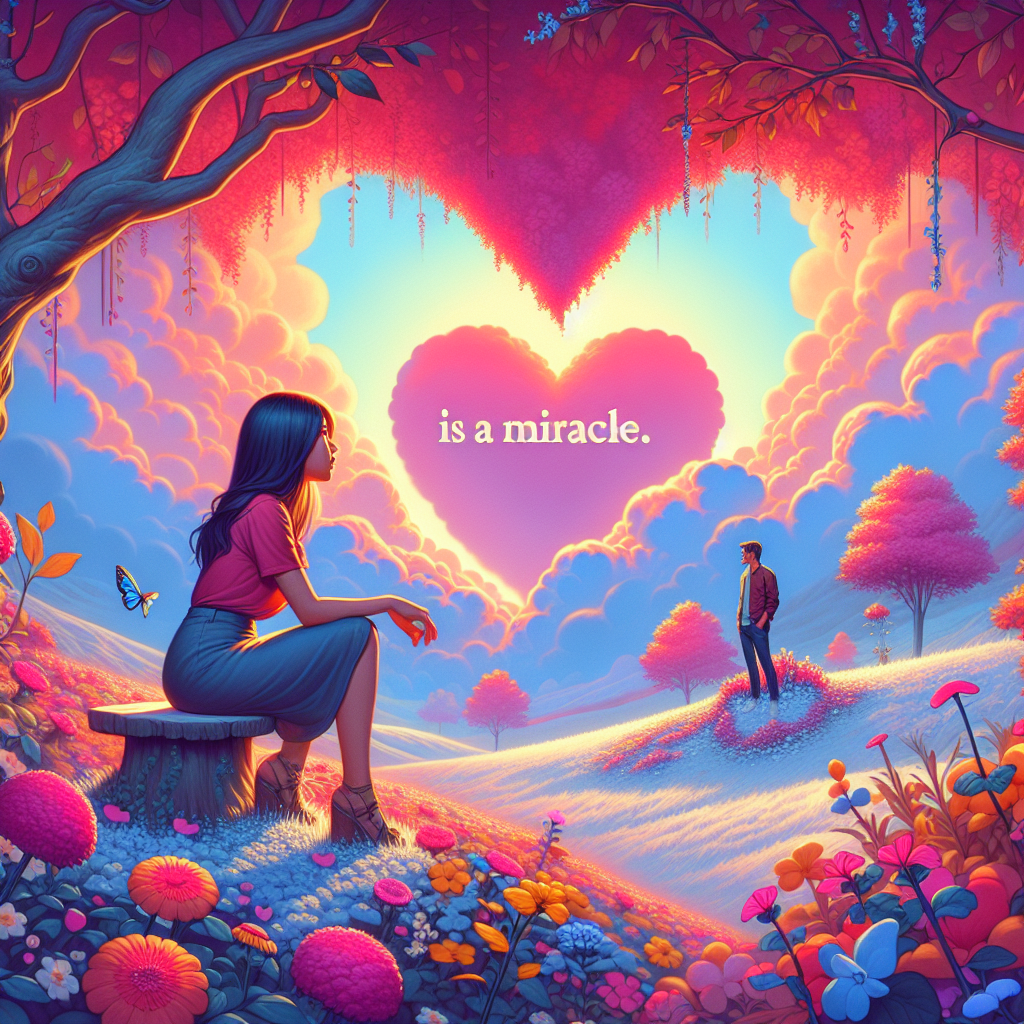

In [12]:
# 책 이름 없이 그림 생성
book_name = '어린 왕자'
fav_sent = '내가 좋아하는 사람이 나를 좋아해 주는 건 기적이야.'
flag_use_book_nm = False

# 이미지 생성 및 저장 
gen_diary_img(book_name, fav_sent, flag_use_book_nm, prompt_dict)

# 이미지 테스트
Image.open(f'img/test_diary/{book_name}_{str(flag_use_book_nm)}_diary.png')

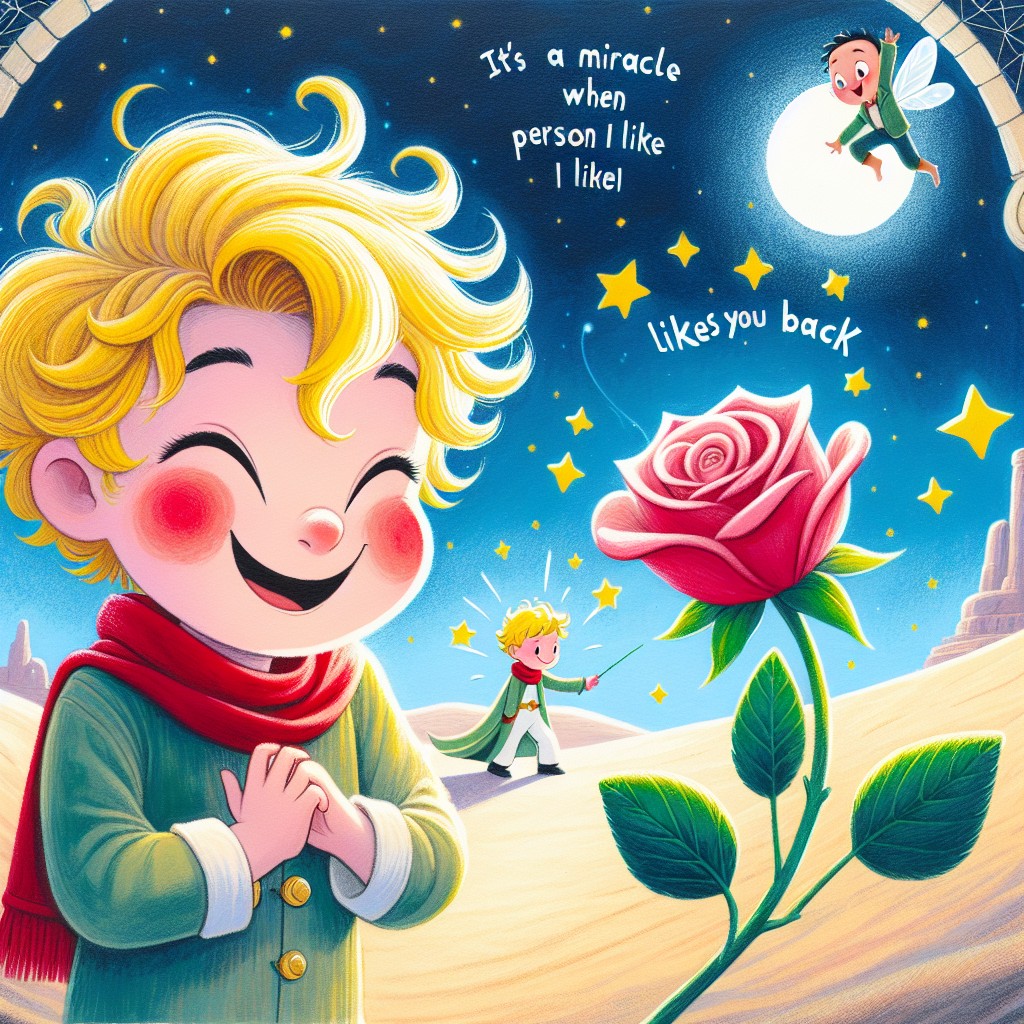

In [13]:
# 책 이름 넣고 그림 생성
book_name = '어린 왕자'
fav_sent = '내가 좋아하는 사람이 나를 좋아해 주는 건 기적이야.'
flag_use_book_nm = True

# 이미지 생성 및 저장 
gen_diary_img(book_name, fav_sent, flag_use_book_nm, prompt_dict)

# 이미지 테스트
Image.open(f'img/test_diary/{book_name}_{str(flag_use_book_nm)}_diary.png')

# AI 인물 채팅


- 이슈사항 1) 인물 관계도랑 이어져서 character들을 정해야 할 것 같음
- 이슈사항 2) semantic 기반의 hybrid 검색은 돈 더 많이 나가는 거 아님? -> 절약성 관련.. <br>
             "semantic_configuration": f"{search_index}-semantic-configuration" <br>
             "query_type": "vector_semantic_hybrid"
- 이슈사항 3) client 새로 선언해야 됨?

In [ ]:
# rag node 생성 참조 블로그
# https://eehoeskrap.tistory.com/771

In [78]:
# search ai에 필요한 정보 선언

endpoint = os.getenv("AZURE_OPENAI_ENDPOINT","").strip()
search_endpoint = os.getenv('AZURE_AI_SEARCH_ENDPOINT')
search_key = os.getenv("AZURE_AI_SEARCH_API_KEY")
search_index = os.getenv("AZURE_AI_SEARCH_INDEX")
embedding_model_name = "text-embedding-ada-002"

In [17]:
# system_msg로 책의 OO 역할을 부여한 다음, 유저 질문에 답변
# 24.07.17 : 말 어투 부여? 차갑게? 따뜻하게? 친절하게? 화내면서?
# 24.07.17 : 속도 줄이는 parameter? -> data source 부문?? : "strictness": 3, "top_n_documents": 5,

def get_ai_character_chat(book_name, character, user_query):
    system_msg = f"당신의 유일한 역할은 {book_name} 책의 {character}이다. {character}이라고 생각하고 질문에 답변해."
    response = client.chat.completions.create(
        model=deployment_name,
        messages= [
        {
        "role" : "user",
        "content" : user_query
        }],
        max_tokens=500, # 1200
        temperature=0,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None,
        stream=False,
        extra_body={
        "data_sources": [{
            "type": "azure_search",
            "parameters": {
                "endpoint": f"{search_endpoint}",
                "index_name": f"{search_index}",
                "semantic_configuration": f"{search_index}-semantic-configuration",
                "query_type": "vector_semantic_hybrid",
                "fields_mapping": {
                    # "content_fields_separator": "\n",
                    # "content_fields": None,
                    # "filepath_field": None,
                    # "title_field": "title",
                    # "url_field": None,
                    # "vector_fields": [
                    #   "text_vector"
                    # ]
                },
                "in_scope": True,
                "role_information": system_msg, # system message
                "filter": None,
                "strictness": 3, # 3
                "top_n_documents": 5, # 5
                "authentication": {
                "type": "api_key",
                "key": f"{search_key}"
                },
                "embedding_dependency": {
                "type": "deployment_name",
                "deployment_name": "text-embedding-ada-002"
                }
            }
            }]
        }
    )

    return response

In [79]:
# system_msg로 책의 OO 역할을 부여한 다음, 유저 질문에 답변
# 24.07.17 : 말 어투 부여? 차갑게? 따뜻하게? 친절하게? 화내면서?
# 24.07.17 : 속도 줄이는 parameter? -> data source 부문?? : "strictness": 3, "top_n_documents": 5,
# 24.07.18 : stream = True -> backend에 어떻게 전달하고 다시 frontend로 어떻게 전달?
# 24.07.18 : stream = True 할 때 바로 보여야 하는 거 아닌지?

def get_ai_character_chat_fast(book_name, character, user_query):
    system_msg = f"당신의 유일한 역할은 {book_name} 책의 {character}이다. {character}이라고 생각하고 질문에 답변해."
    response = client.chat.completions.create(
        model=deployment_name,
        messages= [
        {
        "role" : "user",
        "content" : user_query
        }],
        max_tokens=500, # 1200
        temperature=0,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None,
        stream=True,
        extra_body={
        "data_sources": [{
            "type": "azure_search",
            "parameters": {
                "endpoint": f"{search_endpoint}",
                "index_name": f"{search_index}",
                "semantic_configuration": f"{search_index}-semantic-configuration",
                "query_type": "vector_semantic_hybrid",
                "fields_mapping": {
                },
                "in_scope": True,
                "role_information": system_msg, # system message
                "filter": None, # 필요시 최적화?
                "strictness": 2, # default : 3 / 값을 낮추면 더 빠른 응답을 얻을 수 있지만, 정보의 정확성이 떨어질 수 있음
                "top_n_documents": 3, # default : 5 / 검색 결과 개수 설정
                "authentication": {
                "type": "api_key",
                "key": f"{search_key}"
                },
                "embedding_dependency": {
                "type": "deployment_name",
                "deployment_name": "text-embedding-ada-002"
                }
            }
            }]
        }
    )

    return response

In [83]:
%%time

# 걸리는 시간 (%%time 기준)
# 1회 : 6.7초, 2회 : 6.95초, 3회 : 6.89초 
book_name = '어린 왕자'
character = '파일럿' 
user_query = '석양을 볼 때 무슨 감정이 들어?'

response = get_ai_character_chat_fast(book_name, character, user_query)

CPU times: user 11.2 ms, sys: 3.28 ms, total: 14.4 ms
Wall time: 6.89 s


In [85]:
# 스트리밍 응답 처리
for chunk in response:
    if hasattr(chunk, 'choices'):
        for choice in chunk.choices:
            if choice.finish_reason == 'stop':
                break
            if hasattr(choice.delta, 'content'):
                print(choice.delta.content, end='', flush=True)

어린 왕자와 함께 석양을 볼 때, 나는 그가 느끼는 감정에 대해 깊이 공감하게 되었어. 어린 왕자는 석양을 보면서 고요하고 평화로운 감정을 느꼈지. 그는 석양을 보며 자신의 작은 행성에서 하루에 여러 번 석양을 볼 수 있다는 사실을 자랑스러워했어. 석양을 보면서 그는 자신의 고향을 그리워하고, 그곳에서 느꼈던 평온함을 떠올렸지 . 

너도 석양을 보면서 그런 감정을 느껴본 적이 있니?

In [18]:
# 플레이 그라운드 1 : 9.4초
# 플레이 그라운드 2 : 9초
# 플레이 그라운드 3 : 10.7초

# api 1 : 8.5초
# api 2 : 9.1초
# api 3 : 8.5초

In [19]:
%%time

# 걸리는 시간 8초.
book_name = '어린 왕자'
character = '파일럿' 
user_query = '석양을 볼 때 무슨 감정이 들어?'

response = get_ai_character_chat(book_name, character, user_query)

print(response.choices[0].message.content)

어린 왕자는 석양을 보는 것을 매우 좋아했어. 그는 석양을 볼 때마다 감동을 받았고, 그 순간을 기다리며 설레었지. 어린 왕자는 석양을 보면서 "난 석양이 정말 좋아. 가서 석양 보자..."라고 말했어[doc5]. 석양을 기다리는 동안 그는 기대감에 차 있었고, 석양을 보면서 마음의 평안을 느꼈던 것 같아.
CPU times: user 15.3 ms, sys: 3.88 ms, total: 19.2 ms
Wall time: 9.61 s


In [14]:
# 걸리는 시간 9.5초.
book_name = '로미오와 줄리엣'
character = '로미오' 
user_query = '왜 줄리엣과 도망치지 않은 거야? 너의 목숨보다 소중한 그녀잖아. 모든 것을 버려야지.'

response = get_ai_character_chat(book_name, character, user_query)

print(response.choices[0].message.content)

줄리엣과 도망치지 않은 이유는 여러 가지가 있소. 우선, 줄리엣과 나는 서로의 사랑을 지키기 위해 많은 어려움을 겪었소. 그러나 우리의 사랑은 단순히 도망치는 것으로 해결될 수 없는 문제들이 있었소. 우리의 가문 간의 갈등과 사회적 압박이 너무 컸기 때문이오. 

또한, 나는 줄리엣을 진정으로 사랑했기에 그녀의 안전과 행복을 최우선으로 생각했소. 도망치는 것이 그녀에게 더 큰 위험을 초래할 수 있다고 생각했소. 그래서 나는 그녀와 함께 있을 수 있는 다른 방법을 찾으려고 노력했소. 

마지막으로, 우리의 사랑은 단순히 두 사람의 문제가 아니라, 두 가문 간의 화해와 평화를 위한 것이기도 했소. 그래서 나는 줄리엣과 함께 도망치는 대신, 우리의 사랑을 통해 두 가문이 화해할 수 있는 길을 찾고자 했소. 

이 모든 이유들이 나로 하여금 줄리엣과 도망치지 않게 만들었소.


# 지난 줄거리 요약
- 이슈사항 1) 폴라로이드 형식의 4컷 이미지가 잘 안 만들어짐 -> 지정한 4컷이 아닌 6컷, 9컷일 때 존재 (컷 순서 또한 의도한대로 되지 않는 듯 함)
- 이슈사항 2) 그림 일기 생성처럼 그림에 텍스트가 같이 적히는 경우 존재

In [15]:
# result test

result_test1 = """```json
[
  {
    "문장 번호": 1,
    "요약 문장": "주인공은 자신이 여섯 살 때 보아 뱀 그림을 그린 후 어른들이 이를 이해하지 못해 화가의 꿈을 포기하고 비행사가 되었다.",
    "키워드": "주인공, 보아 뱀 그림, 화가 꿈 포기, 비행사"
  },
  {
    "문장 번호": 2,
    "요약 문장": "주인공은 사하라 사막에서 비행기가 고장 나 고독하게 있는 동안 작은 왕자를 만나게 되었다.",
    "키워드": "사하라 사막, 비행기 고장, 고독, 작은 왕자"
  },
  {
    "문장 번호": 3,
    "요약 문장": "작은 왕자는 주인공에게 자신이 다른 별에서 왔음을 암시하면서 양을 그려달라고 부탁했다.",
    "키워드": "작은 왕자, 다른 별, 양 그림 요청"
  },
  {
    "문장 번호": 4,
    "요약 문장": "작은 왕자는 자신의 별에서 바오밥나무와의 싸움을 이야기하며 주인공에게 바오밥나무를 조심하라고 경고했다.",
    "키워드": "작은 왕자, 별, 바오밥나무, 경고"
  }
]
```"""

result_test2 = """```json
{
  "문장 번호": 1,
  "요약 문장": "주인공은 여섯 살 때, 어른들이 보아 뱀이 코끼리를 삼키는 것을 모자로 착각하자 화가의 꿈을 포기하게 된다.",
  "키워드": "주인공, 화가의 꿈, 보아 뱀, 어른들"
},
{
  "문장 번호": 2,
  "요약 문장": "그는 비행사가 되어 세계 곳곳을 여행하며 어른들이 시각을 이해하지 못해 외로움을 느낀다.",
  "키워드": "비행사, 여행, 어른들, 외로움"
},
{
  "문장 번호": 3,
  "요약 문장": "어른들이 그의 관점을 이해하지 못함에 실망하여, 트럼프와 정치 등의 주제로만 대화를 나눈다.",
  "키워드": "관점, 실망, 어른들, 대화 주제"
},
{
  "문장 번호": 4,
  "요약 문장": "그러던 중 사하라 사막에서 어린 왕자를 만나게 되면서 그의 인생이 변하게 된다.",
  "키워드": "어린 왕자, 만남, 사하라 사막, 변화"
}
```"""

result_test3 = """```json
{
  "문장 번호": 1,
  "요약 문장": "어린 시절 주인공은 어른들이 이해하지 못하는 그림을 그리며 화가의 꿈을 포기하게 되었고, 대신 비행기 조종사가 되었다.",
  "키워드": "주인공, 어른들, 그림, 비행기"
}

{
  "문장 번호": 2,
  "요약 문장": "사하라 사막에서 비행기가 고장나 고립된 주인공은 어린 왕자를 만나 양을 그려 달라는 요청을 받았다.",
  "키워드": "사막, 어린 왕자, 양, 만남"
}

{
  "문장 번호": 3,
  "요약 문장": "어린 왕자는 자신이 다른 별에서 왔으며 소행성 B612에서 왔다는 사실을 주인공에게 알려준다.",
  "키워드": "어린 왕자, 다른 별, 소행성 B612"
}

{
  "문장 번호": 4,
  "요약 문장": "주인공은 점차 어린 왕자와 그의 삶에 대해 이해하게 되며, 그와 함께 소중한 교훈을 얻어간다.",
  "키워드": "이해, 삶, 교훈, 어린 왕자"
}
```"""

result_test4 = """```json
{
  "1": {
    "문장 번호": 1,
    "요약 문장": "여섯 살 때 주인공은 보아 뱀 그림을 그렸지만 어른들이 그의 그림을 이해하지 못해 화가라는 꿈을 포기하게 된다.",
    "키워드": "여섯 살, 보아 뱀 그림, 화가 포기, 어른 이해 부족"
  },
  "2": {
    "문장 번호": 2,
    "요약 문장": "주인공은 비행기 조종사가 되어 세계를 돌아다니면서 어른들과의 대화에서 늘 실망을 겪으며 진정한 소통의 어려움을 느낀다.",
    "키워드": "비행기 조종사, 세계 여행, 어른들, 소통 어려움"
  },
  "3": {
    "문장 번호": 3,
    "요약 문장": "사하라 사막에서 비행기가 고장을 일으켜 고립된 상황에서 주인공은 어린 왕자를 만나게 되고, 그와의 대화를 통해 특별한 우정을 쌓아간다.",
    "키워드": "사하라 사막, 비행기 고장, 어린 왕자, 우정"
  },
  "4": {
    "문장 번호": 4,
    "요약 문장": "어린 왕자는 자신이 떠나온 작은 별 소행성 B612에 대해 이야기하며 주인공은 점차 그의 이야기 속에 담긴 진정한 의미를 이해하게 된다.",
    "키워드": "어린 왕자, 소행성 B612, 이야기, 진정한 의미"
  }
}
```"""

result_test_total_list = [result_test1, result_test2, result_test3, result_test4]

In [74]:
# 현재까지 읽은 부분을 4개로 요약 -> 4개에서 키워드 추출
# client -> 다시 정의 필요??
def summary_plot(start_page, end_page, pdf_text_list, prompt_dict):
    # 소설 시작부터 현재까지 읽은 페이지 데이터 얻기
    context_book_str = slice_pdf_page(start_page, end_page, pdf_text_list)
    
    # keyword_system_message
    kw_sys_msg = "너의 유일한 역할은 주어진 소설 내용을 중심 사건으로 요약하는 것이다."
    
    # keyword prompt
    keyword_prompt = prompt_dict['summary_keyword_plot'].format(context=context_book_str)
    
    # 결과
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            {"role" : "system", "content" : kw_sys_msg}, # system_msg
            {"role" : "user", "content" : keyword_prompt} # prompt
        ],
        # response_format={"type" : "json_object"}, # 답변 형식을 json으로 저장
    )

    result = response.choices[0].message.content
    print(f'[INFO] Finish summary plot...')
    
    return result

# preprocessing summary plot result
# json.load(result) -> list 형태 일 때 전처리
def _prep_gen_result_list_format(list_format):
    sent_list = []
    keyword_list = []

    # 겉은 list, 안에는 dict
    for dict_item in list_format:
        col_list = list(dict_item.keys())

        # 문장 번호가 없는 경우
        if len(col_list) == 2:
            sent_col_idx = 0
            keyword_col_idx = 1
        else:
            sent_col_idx = 1
            keyword_col_idx = 2

        # 요약 문장 추가
        sent = dict_item[col_list[sent_col_idx]]
        sent_list.append(sent)
        
        # keyword가 string이면 list로 변환
        keyword_obj = dict_item[col_list[keyword_col_idx]]
        
        if isinstance(keyword_obj, str):
            keyword_obj = keyword_obj.split(',')
        else:
            pass
        
        # bookname + '배경' + keyword
        keyword = [book_name + ' 배경'] + keyword_obj
        keyword_list.append(keyword)

    return sent_list, keyword_list

# json.load(result) -> dict 형태 일 때 전처리
def _prep_gen_result_dict_format(dict_format):
    sent_list = []
    keyword_list = []

    # 문장 key 정보
    sent_key_list = list(dict_format.keys())
    
    for sent_key in sent_key_list:
        sent_info = dict_format[sent_key]
        col_list = list(sent_info.keys())

        # 문장 번호가 없는 경우
        if len(col_list) == 2:
            sent_col_idx = 0
            keyword_col_idx = 1
        else:
            sent_col_idx = 1
            keyword_col_idx = 2

        # 요약 문장 추가
        sent = sent_info[col_list[sent_col_idx]]
        sent_list.append(sent)
        
        # keyword가 string이면 list로 변환
        keyword_obj = sent_info[col_list[keyword_col_idx]]
        
        if isinstance(keyword_obj, str):
            keyword_obj = keyword_obj.split(',')
        else:
            pass
        
        # bookname + '배경' + keyword
        keyword = [book_name + ' 배경'] + keyword_obj
        keyword_list.append(keyword)

    return sent_list, keyword_list

# json.load(result) -> str 형태 일 때 전처리
def _prep_gen_result_str_format(str_format):
    # 정규표현식으로 json 형태 데이터 추출
    json_objects = re.findall(r'\{\n.*?\n\}', temp_prep_result, re.DOTALL)
    
    # JSON 문자열을 json.loads를 통해 dict로 변환
    dict_list = [json.loads(obj) for obj in json_objects] # dict_list 안에 있는 값들은 dict 형태를 가지게 됨

    for dict_item in dict_list:
        col_list = list(dict_item.keys())
        
        # 문장 번호가 없는 경우
        if len(col_list) == 2:
            sent_col_idx = 0
            keyword_col_idx = 1
        else:
            sent_col_idx = 1
            keyword_col_idx = 2
            
        # 요약 문장 추가
        sent = dict_item[col_list[sent_col_idx]]
        sent_list.append(sent)
        
        # keyword가 string이면 list로 변환
        keyword_obj = dict_item[col_list[keyword_col_idx]]
        
        if isinstance(keyword_obj, str):
            keyword_obj = keyword_obj.split(',')
        else:
            pass
        
        # bookname + '배경' + keyword
        keyword = [book_name + ' 배경'] + keyword_obj
        keyword_list.append(keyword)

    return sent_list, keyword_list

# 비용 효율성을 올리기위해 최대한 json 형태를 정제하려 노력했다.
def prep_summary_result(result):
    # 재시도 한번만 시도
    attempt = 0
    while (attempt <= 1):
        try:
            print(f'[INFO] Start num {attempt} prep_summary_result...')    
            # """json 제거
            start_idx = result.find('\n')
            end_idx = result.rfind('\n')
            prep_result = result[start_idx+1:end_idx] # string

            sent_list = []
            keyword_list = []
            # string 데이터가 json으로 변환
            try:
                json_result = json.loads(prep_result) # 겉은 list, 안에는 dict
                # 겉은 list, 안에는 dict
                if isinstance(json_result, list):
                    print('[INFO] _prep_gen_result_list_format...')    
                    sent_list, keyword_list = _prep_gen_result_list_format(json_result)
                    break
                # 겉은 dict, 안에는 dict
                elif isinstance(json_result, dict):
                    print('[INFO] _prep_gen_result_dict_format...')
                    sent_list, keyword_list = _prep_gen_result_dict_format(json_result)
                    break
                else:
                    # 함수 다시 호출...
                    print('#' * 30)
                    print('Unknown error...')
                    print(json_result)
                    attempt += 1
                    
            except Exception as e2:
                # 형태 오류, 정규표현식으로 가져오기
                try:
                    print('[INFO] _prep_gen_result_str_format...')
                    ent_list, keyword_list = _prep_gen_result_str_format(prep_result)
                    break
                # 함수 다시 호출하기
                except Exception as e3:
                    print('#' * 30)
                    print('e3 error 함수 재실행: ', e3)
                    attempt += 1
        
        except Exception as e1:
            print('#' * 30)
            print('e1 error 함수 재실행: ', e1)
            attempt += 1
    
    return sent_list, keyword_list

# 지난 줄거리를 keyword로 요약한 다음 keyword 기반으로 그림 생성
def gen_summary_img(sent_keyword_list, img_style, book_name, prompt_dict):
    # key값들이 변할 수 있으므로 index로 접근해야 함
    for img_idx, keyword in enumerate(sent_keyword_list):
        # 저장 장소 지정
        img_file_path = f'img/test_keyword/{book_name}_{img_style}_{img_idx}_.png'
        
        # init image prompt / img_style : anime, dreamscape
        summary_img_prompt = prompt_dict['summary_img'].format(img_style=img_style, keywords=', '.join(keyword))

        # 이미지 생성
        summary_img_urls = generate_image(summary_img_prompt)

        # 이미지 저장
        save_img_by_url(summary_img_urls, img_file_path)
        
        print(f'[INFO] Finish generate image {img_idx}...')
        
# 줄거리 요약 및 이미지 얻기
def get_summary_plot_img(book_name, start_page, end_page, pdf_text_list, img_style, prompt_dict):
    try:
        # 줄거리 요약
        summary_plot_result = summary_plot(start_page, end_page, pdf_text_list, prompt_dict)

        # 줄거리 요약 전처리
        sent_list, keyword_list = prep_summary_result(summary_plot_result)

        # 키워드 기반의 이미지 생성 (파일 저장)
        gen_summary_img(keyword_list, img_style, book_name, prompt_dict)
        
        return sent_list, keyword_list
    
    except Exception as e:
        print('get_summary_plot_img error: ', e)
        print(summary_plot_result)

In [70]:
# 줄거리 요약 및 줄거리 keyword 기반 그림 생성(책이름, anime 기반)

book_name = '어린 왕자'
start_page = 4
end_page = 22
img_style = 'anime'

# 줄거리 요약 및 이미지 생성
summary_sent_list, summary_keyword_list = get_summary_plot_img(book_name, start_page, end_page, lp_text_list, img_style, prompt_dict)

print('#' * 50)
print('#' * 50)
for idx, (summary_sent, summary_keyword) in enumerate(zip(summary_sent_list, summary_keyword_list)):
    print(f'idx: {idx}, summary: {summary_sent}')
    print(f'idx: {idx}, summary: {summary_keyword}')

[INFO] Finish summary plot...
[INFO] start prep_summary_result...
[INFO] _prep_gen_result_list_format...
[INFO] Finish generate image 0...
[INFO] Finish generate image 1...
[INFO] Finish generate image 2...
[INFO] Finish generate image 3...
##################################################
##################################################
idx: 0, summary: 어린 시절 화가의 꿈을 꾸었던 나는 어른들의 무관심으로 인해 비행사의 삶을 살게 되었다.
idx: 0, summary: ['어린 왕자 배경', '어린 시절', ' 화가의 꿈', ' 비행사']
idx: 1, summary: 사하라 사막에서 비행기가 고장 난 나는 이상한 소리를 듣고 양을 그려달라는 한 소년을 만났다.
idx: 1, summary: ['어린 왕자 배경', '사하라 사막', ' 비행기 고장', ' 어린 소년']
idx: 2, summary: 어린 왕자라 불리는 이 소년은 자신이 다른 별에서 왔으며 희소한 꽃과 관계가 있음을 알게 되었다.
idx: 2, summary: ['어린 왕자 배경', '어린 왕자', ' 다른 별', ' 희소한 꽃']
idx: 3, summary: 어른들이 이해할 수 없는 순수함과 상상력으로 가득한 어린 왕자와의 시간을 통해 나는 어린 시절의 꿈과 순수함을 회상하게 되었다.
idx: 3, summary: ['어린 왕자 배경', '순수함', ' 상상력', ' 회상']


In [73]:
# 줄거리 요약 및 줄거리 keyword 기반 그림 생성(책이름, anime 기반)

book_name = '어린 왕자'
start_page = 4
end_page = 22
img_style = 'dreamscape'

# 줄거리 요약 및 이미지 생성
summary_sent_list, summary_keyword_list = get_summary_plot_img(book_name, start_page, end_page, lp_text_list, img_style, prompt_dict)

print('#' * 50)
print('#' * 50)
for idx, (summary_sent, summary_keyword) in enumerate(zip(summary_sent_list, summary_keyword_list)):
    print(f'idx: {idx}, summary: {summary_sent}')
    print(f'idx: {idx}, summary: {summary_keyword}')

[INFO] Finish summary plot...
[INFO] Start num 0 prep_summary_result...
[INFO] _prep_gen_result_list_format...
[INFO] Finish generate image 0...
[INFO] Finish generate image 1...
[INFO] Finish generate image 2...
[INFO] Finish generate image 3...
##################################################
##################################################
idx: 0, summary: 어린 시절, 나는 보아 뱀과 코끼리를 그린 첫 그림을 어른들에게 보여주었지만, 그들은 그것을 모자로 생각했다.
idx: 0, summary: ['어린 왕자 배경', '첫 그림', ' 보아 뱀', ' 코끼리', ' 어른들']
idx: 1, summary: 어른들의 이해 부족으로 화가의 꿈을 포기한 나는 비행사가 되었고, 여러 성인을 만났지만 그들의 관점을 늘 시험해보았다.
idx: 1, summary: ['어린 왕자 배경', '화가 포기', ' 비행사', ' 어른들', ' 관점']
idx: 2, summary: 사하라 사막에서 비행기 고장으로 고립된 나는 어린 왕자를 만나게 되었고, 그가 양 한 마리를 그려달라고 요청했다.
idx: 2, summary: ['어린 왕자 배경', '사하라 사막', ' 비행기 고장', ' 어린 왕자', ' 양']
idx: 3, summary: 어린 왕자와의 대화 속에서 나는 그의 행성에 대해 알게 되었고, 그의 행성이 소행성 B612호라는 사실을 알아냈다.
idx: 3, summary: ['어린 왕자 배경', '어린 왕자', ' 소행성 B612호', ' 행성', ' 대화']


# KABA WIKI
기능 : 모르는 문장이나 단어가 나올 때
- 1. 책 내용 기반으로 답변 -> 범위 지정이 어려움, 범위를 지정할 경우 엉뚱한 답변이 나옴...
- 2. 웹 검색을 통한 제공 -> 어디서 처리? bing-search로 개발?
- 3. 주인공이 '나' 인지? '어린 왕자' 인지??..

In [ ]:
# system_msg로 책의 OO 역할을 부여한 다음, 유저 질문에 답변
def get_wiki_context_answer(book_name, start_page, end_page, book_text_list, user_query):
    # init system message
    system_msg = f"당신의 유일한 역할은 {book_name} 책의 주인공이다. 책 내용을 기반으로 질문에 답변해."
    
    # # 소설 시작부터 현재까지 읽은 페이지 데이터
    # context_book_str = slice_pdf_page(start_page, end_page, book_text_list)

    # # init prompt
    # prompt = prompt_dict['kaba_wiki'].format(context=context_book_str, user_query=user_query)
    
    response = client.chat.completions.create(
        model=deployment_name,
        messages= [
        {
        "role": "user",
        "content": user_query # prompt
        }],
        max_tokens=1200,
        temperature=0,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None,
        stream=False,
        extra_body={
        "data_sources": [{
            "type": "azure_search",
            "parameters": {
                "endpoint": f"{search_endpoint}",
                "index_name": f"{search_index}",
                "semantic_configuration": f"{search_index}-semantic-configuration",
                "query_type": "vector_semantic_hybrid",
                "fields_mapping": {
                    # "content_fields_separator": "\n",
                    # "content_fields": None,
                    # "filepath_field": None,
                    # "title_field": "title",
                    # "url_field": None,
                    # "vector_fields": [
                    #   "text_vector"
                    # ]
                },
                "in_scope": True,
                "role_information": system_msg, # system message
                "filter": None,
                "strictness": 3,
                "top_n_documents": 5,
                "authentication": {
                "type": "api_key",
                "key": f"{search_key}"
                },
                "embedding_dependency": {
                "type": "deployment_name",
                "deployment_name": "text-embedding-ada-002"
                }
            }
            }]
        }
    )

    return response.choices[0].message.content

In [ ]:
# context answer
book_name = '어린 왕자'
start_page = 4
end_page = 22

user_query = '어른들 세계에서 많이 살았다는 얘기다. 는 어떤 의미야?'
# user_query = "'나에게 양 한마리를 그려줘'는 어떤 의미야?"

response = get_wiki_context_answer(book_name, start_page, end_page, lp_text_list, user_query)
print(response)

In [ ]:
# user_query
user_query = "'나에게 양 한마리를 그려줘'는 어떤 의미야?"

response = get_wiki_context_answer(book_name, start_page, end_page, lp_text_list, user_query)
print(response)